**Run Expense Categorization Model (SVM, Naive Bayes, Decision Tree, KNN & BERT)**

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

%pip install 'accelerate>=0.26.0'




Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'accelerate": Expected package name at the start of dependency specifier
    'accelerate
    ^


### Expense Categorization: 5-Model Comparison (DT, KNN, SVM, NB, BERT)

In [42]:

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,validation_curve,train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import joblib
import os

### Disable Weights & Biases logging to prevent login prompt ---

In [43]:
os.environ["WANDB_DISABLED"] = "true"

os.makedirs('saved_models', exist_ok=True)

### 1. DATA PREPARATION

In [44]:
csv_filename = r"D:\nodejsProject\classification/receipt_dataset_6000.csv"

# try:
    # print(f"Loading {csv_filename}...")
df = pd.read_csv(csv_filename)
    # print("✅ Data Loaded Successfully!")
# except FileNotFoundError:
#     print(f"❌ Error: {csv_filename} not found.")
#     sys.exit(1)

### Split Data
### Vectorization (Needed for all traditional ML models)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
print("-" * 50)

Training samples: 4800, Testing samples: 1200
--------------------------------------------------


### 2. TRADITIONAL ML (4 Models)

In [46]:
print("Running Traditional Machine Learning Models...")
ml_results = {}

Running Traditional Machine Learning Models...


### --- A. Naive Bayes (NB) ---

In [47]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_acc = accuracy_score(y_test, nb_model.predict(X_test_tfidf))
ml_results['Naive Bayes'] = nb_acc
print(f"✅ Naive Bayes Accuracy: {nb_acc:.4f}")




✅ Naive Bayes Accuracy: 1.0000


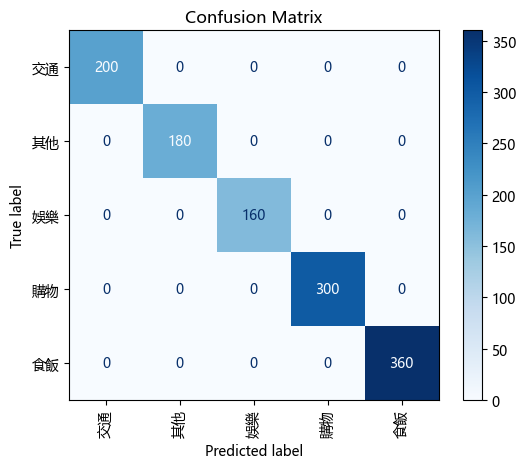

In [ ]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 

plt.rcParams['axes.unicode_minus'] = False

y_pred = nb_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred, labels=nb_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_model.classes_)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [49]:
print(classification_report(y_test, y_pred, target_names=nb_model.classes_))

              precision    recall  f1-score   support

          交通       1.00      1.00      1.00       200
          其他       1.00      1.00      1.00       180
          娛樂       1.00      1.00      1.00       160
          購物       1.00      1.00      1.00       300
          食飯       1.00      1.00      1.00       360

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



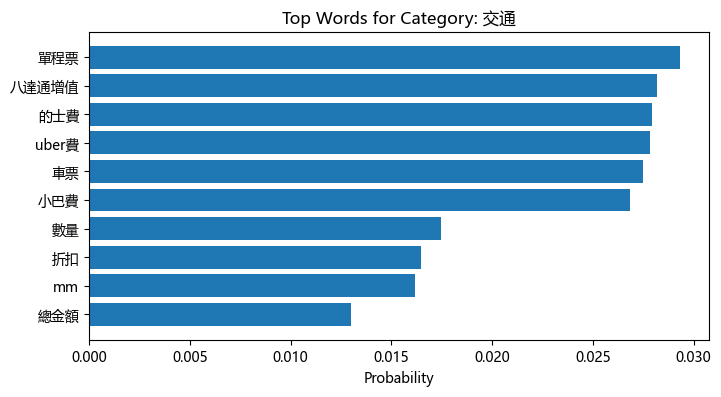

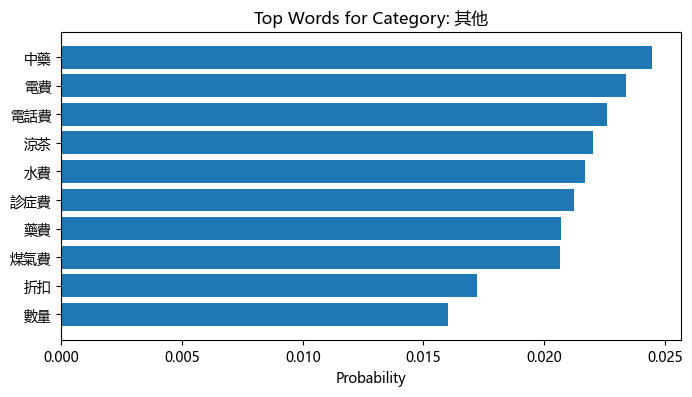

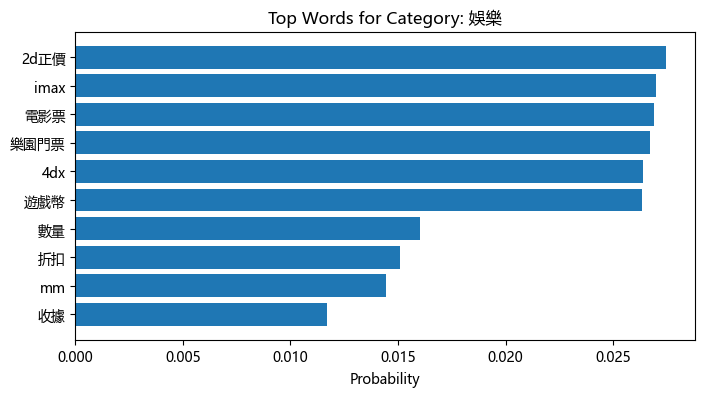

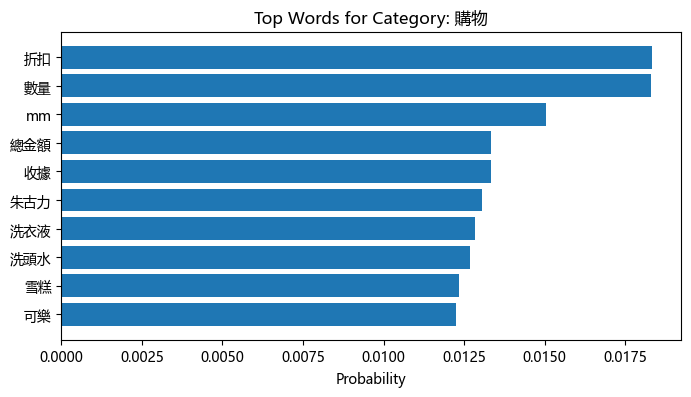

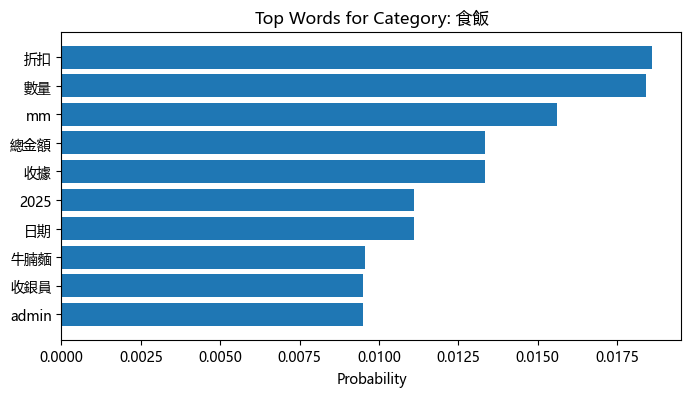

In [50]:
feature_names = vectorizer.get_feature_names_out()
log_prob = nb_model.feature_log_prob_

for i, class_label in enumerate(nb_model.classes_):
    top10 = np.argsort(log_prob[i])[-10:]
    top_words = [feature_names[j] for j in top10]
    top_scores = log_prob[i][top10]
    
    plt.figure(figsize=(8, 4))
    plt.barh(top_words, np.exp(top_scores))  # exp to get actual probabilities
    plt.title(f'Top Words for Category: {class_label}')
    plt.xlabel('Probability')
    plt.show()

### --- B. Support Vector Machine (SVM) ---

In [51]:
svm_model = SVC(kernel='linear', C=1.0)
svm_model.fit(X_train_tfidf, y_train)
svm_acc = accuracy_score(y_test, svm_model.predict(X_test_tfidf))
# ml_results['SVM'] = svm_acc
print(f"✅ SVM Accuracy: {svm_acc:.4f}")

✅ SVM Accuracy: 1.0000


In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear']
}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_tfidf, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

svm_model = grid.best_estimator_
svm_acc = accuracy_score(y_test, svm_model.predict(X_test_tfidf))
print(f"✅ SVM Test Accuracy: {svm_acc:.4f}")

ml_results['SVM'] = svm_acc

Best parameters: {'C': 0.1, 'kernel': 'linear'}
Best CV accuracy: 1.0
✅ SVM Test Accuracy: 1.0000


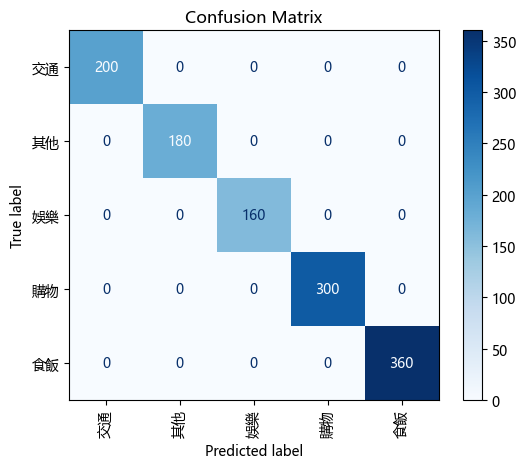

In [91]:
y_pred = svm_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred, labels=svm_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

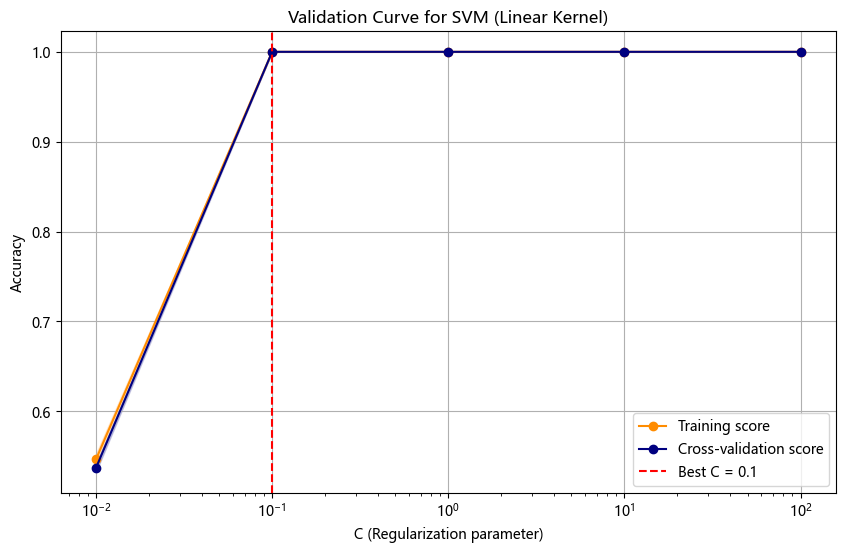

In [53]:
param_range = [0.01, 0.1, 1, 10, 100]

train_scores, val_scores = validation_curve(
    SVC(kernel='linear'),            
    X_train_tfidf, y_train,
    param_name="C",
    param_range=param_range,
    cv=5,                             
    scoring="accuracy",
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label="Training score", color="darkorange", marker='o')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="darkorange")

plt.plot(param_range, val_mean, label="Cross-validation score", color="navy", marker='o')
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2, color="navy")

plt.xscale('log')  
plt.xlabel('C (Regularization parameter)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for SVM (Linear Kernel)')
best_C = grid.best_params_['C']
plt.axvline(x=best_C, color='red', linestyle='--', label=f'Best C = {best_C}')
plt.legend(loc="best")
plt.grid(True)
plt.show()

### --- C. Decision Tree (DT) ---


In [54]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_tfidf, y_train)
dt_acc = accuracy_score(y_test, dt_model.predict(X_test_tfidf))
# ml_results['Decision Tree'] = dt_acc
print(f"✅ Decision Tree Accuracy: {dt_acc:.4f}")

✅ Decision Tree Accuracy: 0.9983


In [86]:
param_grid = {
    'max_depth': [11, 12, 13, 14, 15, 16],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_tfidf, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

dt_model = grid.best_estimator_
dt_acc = accuracy_score(y_test, dt_model.predict(X_test_tfidf))
ml_results['Decision Tree'] = dt_acc
print(f"✅ Decision Tree Test Accuracy: {dt_acc:.4f}")

Best parameters: {'criterion': 'gini', 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV accuracy: 0.9035416666666667
✅ Decision Tree Test Accuracy: 0.9033


c:\Users\User\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


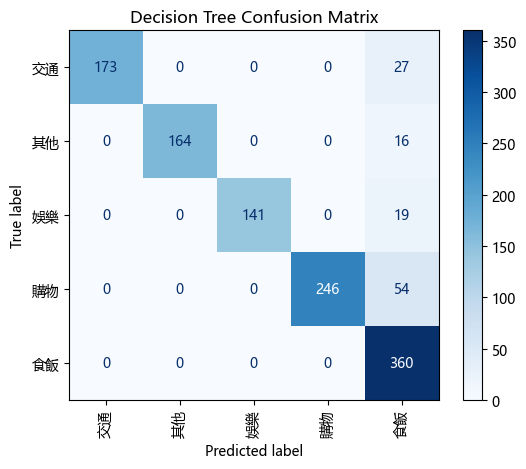

In [87]:
y_pred = dt_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred, labels=dt_model.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=dt_model.classes_)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.show()

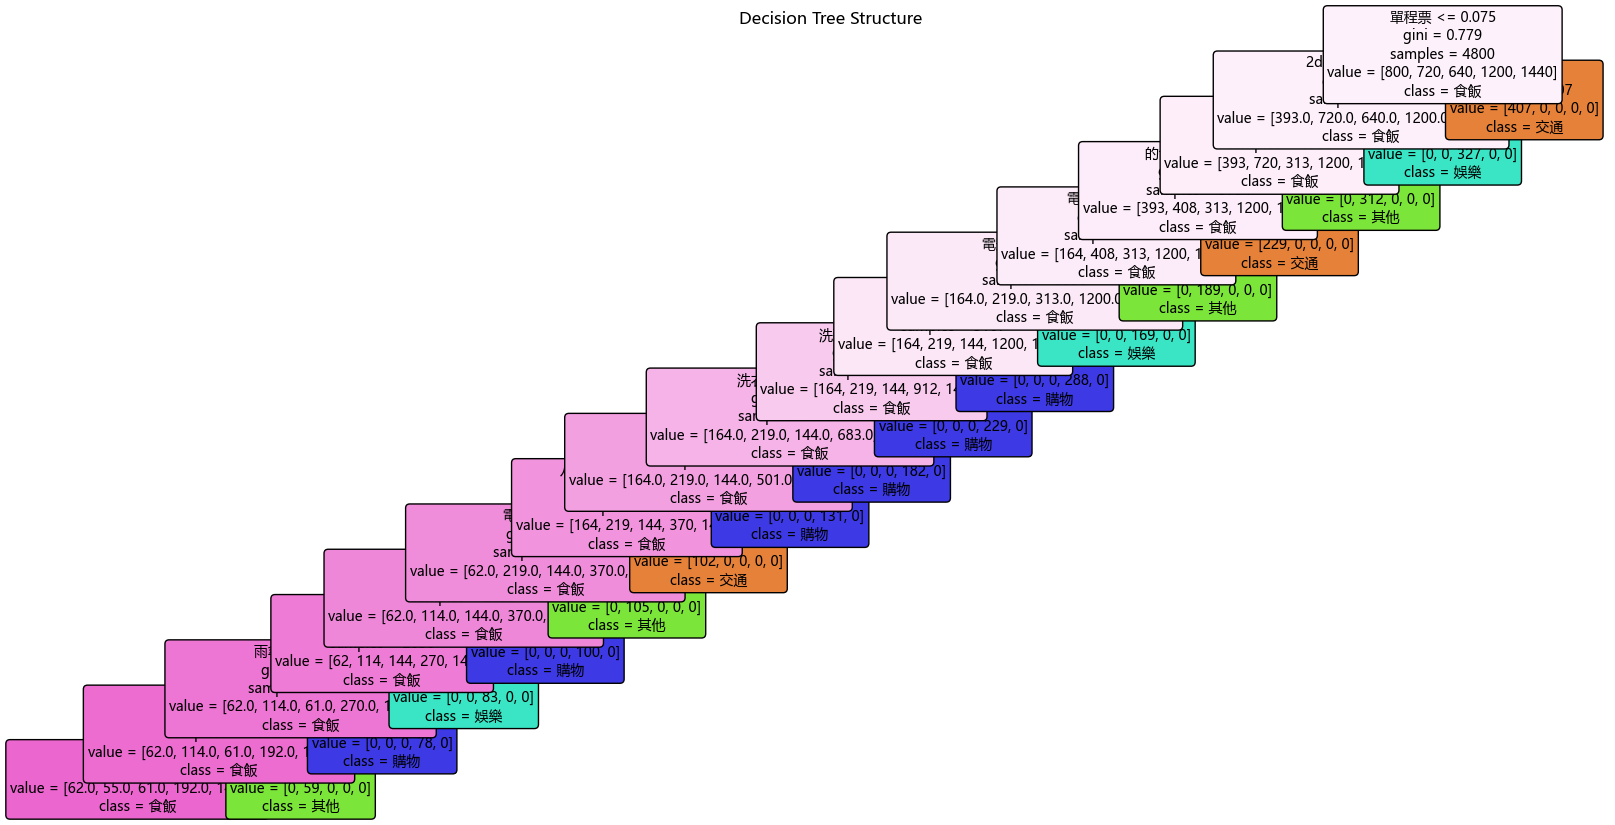

In [88]:
plt.figure(figsize=(20,10))  
plot_tree(dt_model, feature_names=vectorizer.get_feature_names_out(), 
          class_names=dt_model.classes_, filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree Structure')
plt.show()

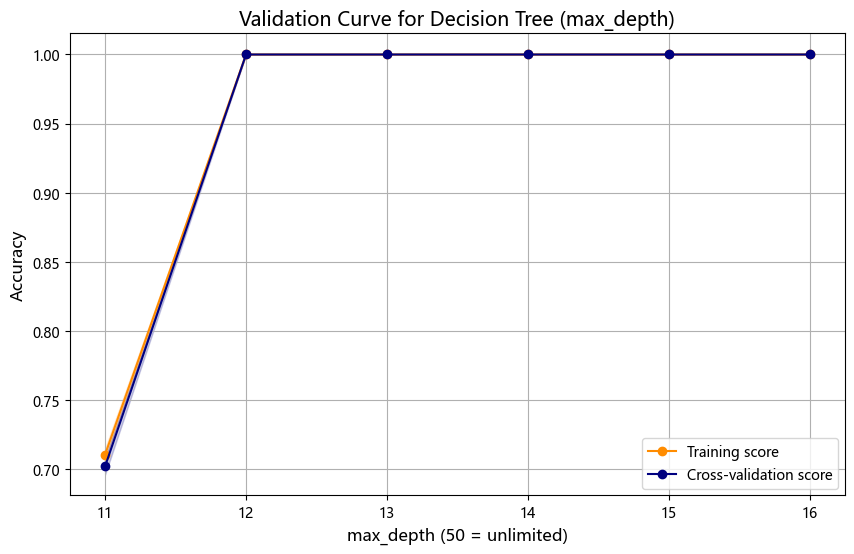

In [92]:
original_param_range = [11, 12, 13, 14, 15, 16]

plot_param_range = [x if x is not None else 50 for x in original_param_range]

plot_param_range = np.array(plot_param_range)

train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

plt.figure(figsize=(10, 6))

plt.plot(plot_param_range, train_mean, label="Training score", color="darkorange", marker='o')
plt.fill_between(plot_param_range, train_mean - train_std, train_mean + train_std, 
                 alpha=0.2, color="darkorange")

plt.plot(plot_param_range, val_mean, label="Cross-validation score", color="navy", marker='o')
plt.fill_between(plot_param_range, val_mean - val_std, val_mean + val_std, 
                 alpha=0.2, color="navy")

plt.title('Validation Curve for Decision Tree (max_depth)', fontsize=14)
plt.xlabel('max_depth (50 = unlimited)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc="best")
plt.grid(True)

x_labels = [str(x) if x != 50 else 'None' for x in plot_param_range]
plt.xticks(plot_param_range, x_labels)

plt.show()

### --- D. K-Nearest Neighbors (KNN) ---
### Using n_neighbors=3 for a simple baseline

In [62]:
knn_model = KNeighborsClassifier(n_neighbors=11)
knn_model.fit(X_train_tfidf, y_train)
knn_acc = accuracy_score(y_test, knn_model.predict(X_test_tfidf))
ml_results['KNN'] = knn_acc
print(f"✅ KNN Accuracy: {knn_acc:.4f}")

print("-" * 50)

✅ KNN Accuracy: 0.9992
--------------------------------------------------


k= 1 → Accuracy: 0.9692
k= 2 → Accuracy: 0.9558
k= 3 → Accuracy: 0.9867
k= 4 → Accuracy: 0.9908
k= 5 → Accuracy: 0.9925
k= 6 → Accuracy: 0.9942
k= 7 → Accuracy: 0.9958
k= 8 → Accuracy: 0.9967
k= 9 → Accuracy: 0.9983
k=10 → Accuracy: 0.9992
k=11 → Accuracy: 0.9992
k=12 → Accuracy: 0.9992
k=13 → Accuracy: 0.9992
k=14 → Accuracy: 1.0000
k=15 → Accuracy: 1.0000
k=16 → Accuracy: 1.0000
k=17 → Accuracy: 1.0000
k=18 → Accuracy: 1.0000
k=19 → Accuracy: 1.0000
k=20 → Accuracy: 1.0000
k=21 → Accuracy: 1.0000
k=22 → Accuracy: 1.0000
k=23 → Accuracy: 1.0000
k=24 → Accuracy: 1.0000
k=25 → Accuracy: 1.0000
k=26 → Accuracy: 1.0000
k=27 → Accuracy: 1.0000
k=28 → Accuracy: 1.0000
k=29 → Accuracy: 1.0000
k=30 → Accuracy: 1.0000

🏆 Best k: 14 with Accuracy: 1.0000


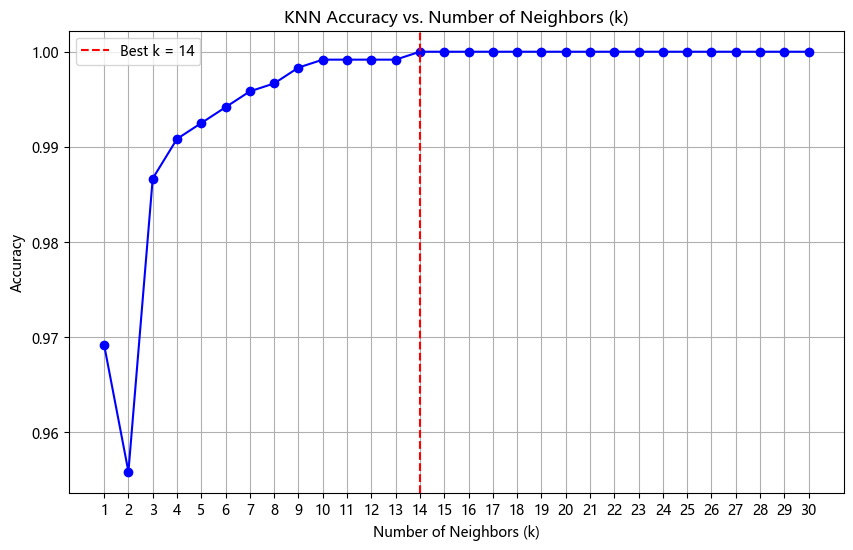

In [63]:
k_values = []
accuracies = []

for k in range(1, 31):
    k_values.append(k)
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_tfidf, y_train)
    
    y_pred = knn.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    
    accuracies.append(acc)
    print(f"k={k:2d} → Accuracy: {acc:.4f}")

best_k = k_values[accuracies.index(max(accuracies))]
best_acc = max(accuracies)

print(f"\n🏆 Best k: {best_k} with Accuracy: {best_acc:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b')
plt.title('KNN Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
plt.legend()
plt.show()

### --- E. Logistic Regression ---

In [ ]:
logistic_model = LogisticRegression(max_iter=1000, C=5)

logistic_model.fit(X_train_tfidf, y_train)
logistic_acc = accuracy_score(y_test, logistic_model.predict(X_test_tfidf))
# ml_results['Logistic Regression'] = logistic_acc

print(f"✅ Logistic Regression Accuracy: {logistic_acc:.4f}")

print("-" * 50)


✅ Logistic Regression Accuracy: 1.0000
--------------------------------------------------


In [64]:
param_grid = {
    'C': [0.01, 0.1, 1, 5, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['saga']  # saga 支援 l1 和 l2
}

grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), 
                    param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_tfidf, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

logistic_model = grid.best_estimator_
logistic_acc = accuracy_score(y_test, logistic_model.predict(X_test_tfidf))
ml_results['Logistic Regression'] = logistic_acc
print(f"✅ Logistic Regression Test Accuracy: {logistic_acc:.4f}")

Best parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Best CV accuracy: 1.0
✅ Logistic Regression Test Accuracy: 1.0000


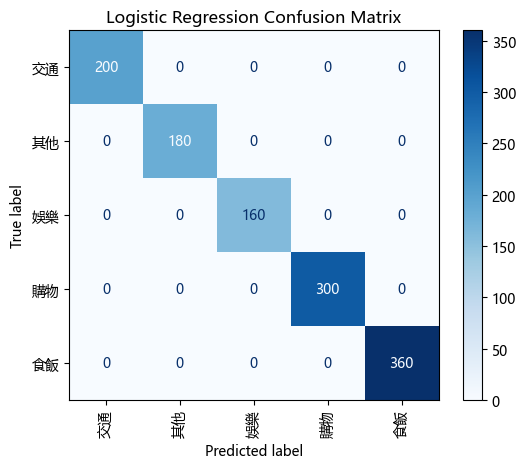

In [65]:
y_pred = logistic_model.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred, labels=logistic_model.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=logistic_model.classes_)
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

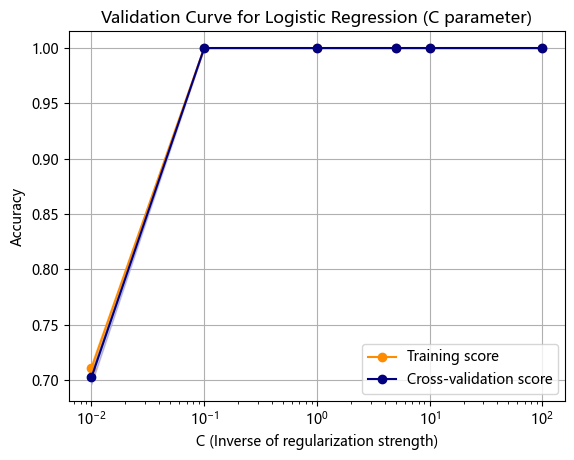

In [66]:
param_range = [0.01, 0.1, 1, 5, 10, 100]

train_scores, val_scores = validation_curve(
    LogisticRegression(max_iter=1000, solver='saga', penalty='l2'),
    X_train_tfidf, y_train, param_name="C", param_range=param_range,
    cv=5, scoring="accuracy", n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std   = np.std(val_scores, axis=1)

# plt.figure(figsize=(10,6))
plt.plot(param_range, train_mean, label="Training score", color="darkorange", marker='o')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.2, color="darkorange")
plt.plot(param_range, val_mean, label="Cross-validation score", color="navy", marker='o')
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, alpha=0.2, color="navy")

plt.xscale('log')
plt.xlabel('C (Inverse of regularization strength)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for Logistic Regression (C parameter)')
plt.legend(loc="best")
plt.grid(True)
plt.show()

### 3. DEEP LEARNING (BERT)

In [93]:
print("Initializing Deep Learning (BERT)...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=5)
model.to(device)

class ExpenseDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=64):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', truncation=True, return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = ExpenseDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = ExpenseDataset(X_test.tolist(), y_test.tolist(), tokenizer)

training_args = TrainingArguments(
    output_dir='./results', num_train_epochs=3, per_device_train_batch_size=8,
    logging_dir='./logs', logging_steps=10,
    report_to="none"
)

trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=test_dataset,
    compute_metrics=lambda p: {"accuracy": accuracy_score(p.label_ids, p.predictions.argmax(-1))}
)

print("Training BERT model (No Login Required)...")
# trainer.train()

# bert_eval = trainer.evaluate()
# bert_acc = bert_eval['eval_accuracy']
# ml_results['BERT'] = bert_acc
# print(f"✅ BERT Accuracy: {bert_acc:.4f}")
# print("-" * 50)


Initializing Deep Learning (BERT)...
Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT model (No Login Required)...


# ==========================================
# 4. PLOTTING COMPARISON
# ==========================================

Generating 5-Model Comparison Plot...


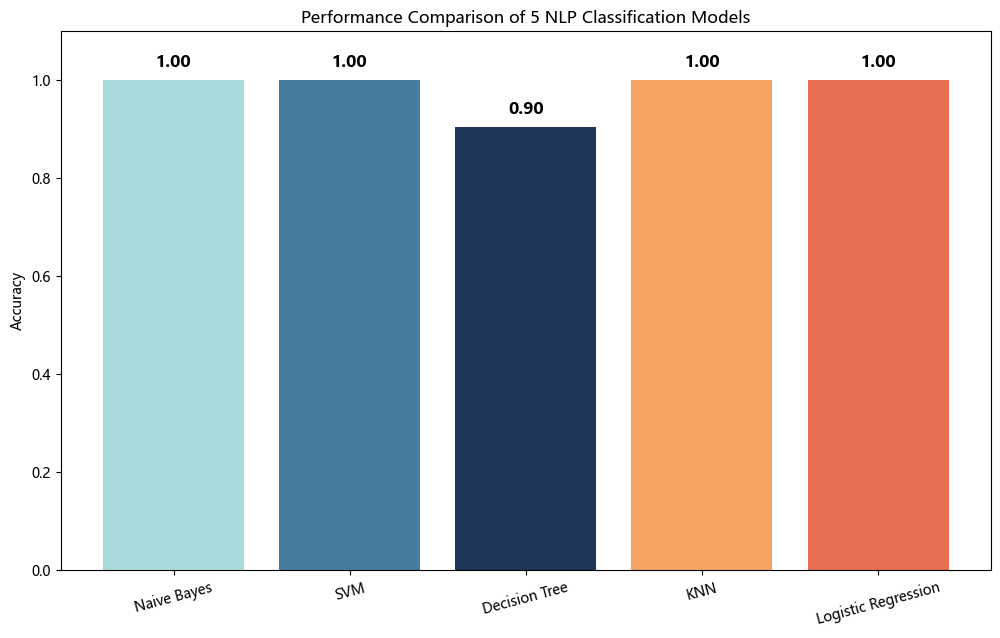

In [94]:
print("Generating 5-Model Comparison Plot...")
models = list(ml_results.keys())
accuracies = list(ml_results.values())

plt.figure(figsize=(12, 7))
# Use a color palette to distinguish ML types
colors = ['#A8DADC', '#457B9D', '#1D3557', '#F4A261', '#E76F51']
bars = plt.bar(models, accuracies, color=colors)
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.title('Performance Comparison of 5 NLP Classification Models')
plt.xticks(rotation=15)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}",
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

# ==========================================
# 5. PREDICTION FUNCTION
# ==========================================

In [95]:

CATEGORY_MAP = {
    0: "Groceries (雜貨/超市購物)", 1: "Transportation (交通)",
    2: "Utilities (公用事業)", 3: "Entertainment (娛樂)",
    4: "Food & Drinks (食物與飲料)"
}

def predict_expense(text_input):
    """Predicts expense category using all five models."""
    global logistic_model,nb_model, svm_model, dt_model, knn_model, model, vectorizer, tokenizer, device, CATEGORY_MAP

    # --- Vectorization ---
    vec = vectorizer.transform([text_input])

    # --- ML Predictions ---
    nb_p = nb_model.predict(vec)[0]
    svm_p = svm_model.predict(vec)[0]
    dt_p = dt_model.predict(vec)[0]
    knn_p = knn_model.predict(vec)[0]
    logistic_p = logistic_model.predict(vec)[0]

    # --- DL Prediction (BERT) ---
    inputs = tokenizer(text_input, return_tensors="pt", truncation=True, padding=True, max_length=64).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    bert_p = logits.argmax().item()

    print(f"\n--- Prediction for: '{text_input}' ---")
    # print(f"**Naive Bayes:** [{nb_p}] {CATEGORY_MAP[nb_p]}")
    # print(f"**SVM:** [{svm_p}] {CATEGORY_MAP[svm_p]}")
    # print(f"**Decision Tree:** [{dt_p}] {CATEGORY_MAP[dt_p]}")
    # print(f"**KNN:** [{knn_p}] {CATEGORY_MAP[knn_p]}")
    # print(f"**BERT:** [{bert_p}] {CATEGORY_MAP[bert_p]}")

    print(f"**Naive Bayes:** [{nb_p}] ")
    print(f"**SVM:** [{svm_p}] ")
    print(f"**Decision Tree:** [{dt_p}] ")
    print(f"**KNN:** [{knn_p}] ")
    print(f"**BERT:** [{bert_p}]")
    print(f"**Logistic Regression:** [{logistic_p}]")
    
    print("-" * 40)



In [96]:
# Test with Examples
print("--- Running Predictions on Test Inputs ---")
predict_expense('Sushi and beer with friends HKD120')
predict_expense('Uber $110.50')
predict_expense('Electric bill')
predict_expense('咖哩牛腩飯')
predict_expense('米線')
predict_expense('Concert tickets for VIP seat USD900')
predict_expense('Socks')
predict_expense('恐龍毛公仔')

--- Running Predictions on Test Inputs ---

--- Prediction for: 'Sushi and beer with friends HKD120' ---
**Naive Bayes:** [食飯] 
**SVM:** [食飯] 
**Decision Tree:** [食飯] 
**KNN:** [購物] 
**BERT:** [0]
**Logistic Regression:** [食飯]
----------------------------------------

--- Prediction for: 'Uber $110.50' ---
**Naive Bayes:** [交通] 
**SVM:** [食飯] 
**Decision Tree:** [食飯] 
**KNN:** [交通] 
**BERT:** [0]
**Logistic Regression:** [食飯]
----------------------------------------

--- Prediction for: 'Electric bill' ---
**Naive Bayes:** [食飯] 
**SVM:** [食飯] 
**Decision Tree:** [食飯] 
**KNN:** [購物] 
**BERT:** [0]
**Logistic Regression:** [食飯]
----------------------------------------

--- Prediction for: '咖哩牛腩飯' ---
**Naive Bayes:** [食飯] 
**SVM:** [食飯] 
**Decision Tree:** [食飯] 
**KNN:** [購物] 
**BERT:** [0]
**Logistic Regression:** [食飯]
----------------------------------------

--- Prediction for: '米線' ---
**Naive Bayes:** [食飯] 
**SVM:** [食飯] 
**Decision Tree:** [食飯] 
**KNN:** [購物] 
**BERT:** [0]
**Logis

In [73]:


# Save the TF-IDF vectorizer (required for all traditional ML models)
joblib.dump(vectorizer, 'saved_models/tfidf_vectorizer.pkl')

# Save traditional ML models
joblib.dump(nb_model, 'saved_models/nb_model.pkl')
joblib.dump(svm_model, 'saved_models/svm_model.pkl')
joblib.dump(dt_model, 'saved_models/dt_model.pkl')
joblib.dump(knn_model, 'saved_models/knn_model.pkl')
joblib.dump(logistic_model, 'saved_models/logistic_model.pkl')

['saved_models/logistic_model.pkl']